In [1]:
import numpy as np
import pandas as pd
import json
import codecs
import datetime
import os
import sys

In [2]:
sys.path.append('.')

In [373]:
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (24, 16)

In [386]:
import oci
import json
from oci.config import validate_config
from sklearn.covariance import MinCovDet 

In [5]:
tenancyId="ocid1.tenancy.oc1..aaaaaaaahkzl4rzvgxjfnrfcj7rzlsdav25h7tsx7kjxyv2bmwkfpzpag26q" # Your tenancies OCID.
authUserId="ocid1.user.oc1..aaaaaaaayltryoz33ole5eubwphwijkcvmi4ukbombh4aym2crp5j6xqxaxq" # The OCID of the user ID being used.
OCI_KEY_PATH="/home/datascience/.oci/oci_api_key.pem" # Path of the key file.
keyFingerprint="9a:47:38:96:c8:4d:bf:7e:32:3d:7c:c3:24:23:71:35" # The fingerprint of the key file being used
namespace = "lrzustouvvrg"
bucket_name = "sdk-initial-data-bucket"
config = {
    "user": authUserId,
    "key_file": OCI_KEY_PATH,
    "fingerprint": keyFingerprint,
    "tenancy": tenancyId,
    "region": "uk-london-1"
}

In [6]:
validate_config(config)

In [7]:
object_storage_client = oci.object_storage.ObjectStorageClient(config)
next_starts_with = None
object_list = object_storage_client.list_objects(namespace, bucket_name , fields='name, timeCreated, size', start=next_starts_with)

In [8]:
f = object_list.data.objects

In [9]:
f[0]

{
  "archival_state": null,
  "etag": null,
  "md5": null,
  "name": "005b6c49-c4ed-438b-9092-ad02ed4d672e_26-07-2021_13-36-18.json",
  "size": 530965,
  "storage_tier": null,
  "time_created": "2021-07-26T05:36:31.229000+00:00",
  "time_modified": null
}

In [10]:
object_list.data.objects[0]

{
  "archival_state": null,
  "etag": null,
  "md5": null,
  "name": "005b6c49-c4ed-438b-9092-ad02ed4d672e_26-07-2021_13-36-18.json",
  "size": 530965,
  "storage_tier": null,
  "time_created": "2021-07-26T05:36:31.229000+00:00",
  "time_modified": null
}

In [11]:
len(f)

1000

In [12]:
obj = object_storage_client.get_object(namespace, bucket_name, f[0].name).data

In [13]:
type(obj.content)

bytes

In [14]:
j_obj = json.loads(obj.content)

In [15]:
type(j_obj)

dict

In [10]:
from vector_creator.score_vectors_assembly import score_vector_from_bucket, normalize_scores

In [ ]:
res0 = score_vector_from_bucket(object_storage_client, 'photo-gallery', next_starts_with)

In [12]:
res0.to_csv('csv_files/photo_gallery_kobi_ver.csv')

In [13]:
next_starts_with = object_list.data.next_start_with

In [14]:
osc = object_storage_client.list_objects(namespace, bucket_name, start=next_starts_with, fields='name, timeCreated, size')
g = osc.data.objects
g[0]

{
  "archival_state": null,
  "etag": null,
  "md5": null,
  "name": "790cffbe-32d1-4c89-b22f-43bbdd3fe6be_13-07-2021_00-28-38.json",
  "size": 62083,
  "storage_tier": null,
  "time_created": "2021-07-12T16:26:22.891000+00:00",
  "time_modified": null
}

In [15]:
len(g)

1000

In [ ]:
res1 = score_vector_from_bucket(object_storage_client, 'photo-gallery', next_starts_with)

In [17]:
res1.to_csv('csv_files/photo_gallery_kobi_ver_2.csv')

In [18]:
res = res0.append(res1)

In [29]:
res.shape

(811, 27)

In [20]:
res.to_csv('csv_files/photo_gallery_kobi_ver_full.csv')

In [ ]:
next_starts_with = object_list.data.next_start_with

In [ ]:
osc = object_storage_client.list_objects(namespace, bucket_name, start=next_starts_with, fields='name, timeCreated, size')
g = osc.data.objects
g[0]

In [ ]:
len(g)

In [ ]:
res2 = score_vector_from_bucket(object_storage_client, 'photo-gallery', next_starts_with)

In [ ]:
res.to_csv('score_vec_photogallery_aggresive.csv')

In [42]:
res.index.is_unique

True

In [43]:
inxs = res.index.values

In [44]:
len(inxs)

811

In [30]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import cycle
import pandas as pd

In [32]:
def normalize_scores(df, method):
    df_scale = df.transpose()
    if len(df) > 20:
        df_scale =  z_score(df_scale) if method == 'z-score' else minmax_scale(df_scale)
    return df_scale.transpose()

In [33]:
from vector_creator.stats_models.estimators import *

In [34]:
nr = normalize_scores(res, 'min-max')

In [35]:
nz = normalize_scores(res, 'z-score')

In [36]:
type(nr)

numpy.ndarray

In [270]:
nz.shape

(811, 27)

--> Start tSNE for 2D 

In [38]:
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=300, method='exact')

In [39]:
tsne_res = tsne.fit_transform(nz)

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 811 / 811
[t-SNE] Mean sigma: 1.346275
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.814583
[t-SNE] KL divergence after 300 iterations: 0.808069


In [45]:
df = pd.DataFrame(tsne_res, columns=['x_col', 'y_col'], index=inxs)

In [46]:
df.shape

(811, 2)

In [271]:
df.head(5)

,x_col,y_col
005b6c49-c4ed-438b-9092-ad02ed4d672e,-6.445101,-9.459874
007a0785-1321-4112-be89-e6549a4725a2,-6.622664,8.609216
00e37960-250f-4185-94ac-143b319730e3,9.927461,-6.759468
025aa94c-bbf4-4e15-9ba1-7a7c18153fce,13.009322,-8.127320
03363918-9d74-4668-89bf-46ea1f05e802,0.846786,-1.998743


<AxesSubplot:xlabel='x_col', ylabel='y_col'>

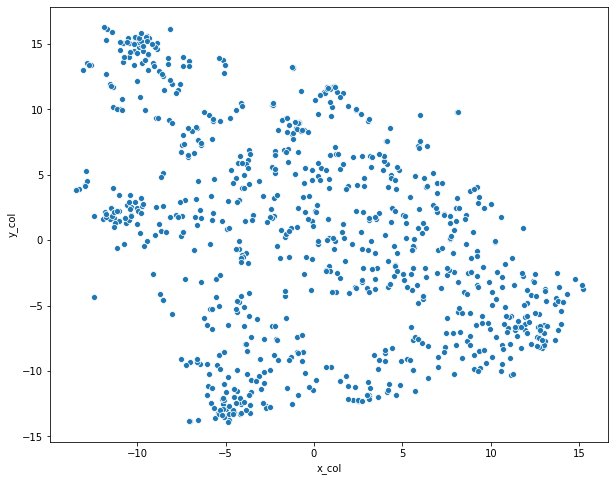

In [48]:
plt.figure(figsize=(10,8))
sns.scatterplot(
    x='x_col', 
    y='y_col',
    data=df
)

--> Mean Shift for tSNE-2D data frame

In [397]:
bandwidth = estimate_bandwidth(df, quantile=0.12)

In [398]:
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(df)

MeanShift(bandwidth=5.387254202432055, bin_seeding=True)

In [399]:
labels = ms.labels_
cluster_centers = ms.cluster_centers_
labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

In [400]:
cluster_centers

array([[  4.431119  ,   0.09215192],
       [ 10.446054  ,  -5.8441925 ],
       [ -0.14183226,   4.668445  ],
       [ -7.31948   ,   2.27914   ],
       [ -3.8561764 , -10.546412  ],
       [ -9.256774  ,  13.035744  ]], dtype=float32)

In [401]:
labels_unique

array([0, 1, 2, 3, 4, 5])

--> Plot tSNE mean-shift 2D with uids as index to df 

b [4.431119   0.09215192] 0
g [10.446054  -5.8441925] 1
r [-0.14183226  4.668445  ] 2
c [-7.31948  2.27914] 3
m [ -3.8561764 -10.546412 ] 4
y [-9.256774 13.035744] 5


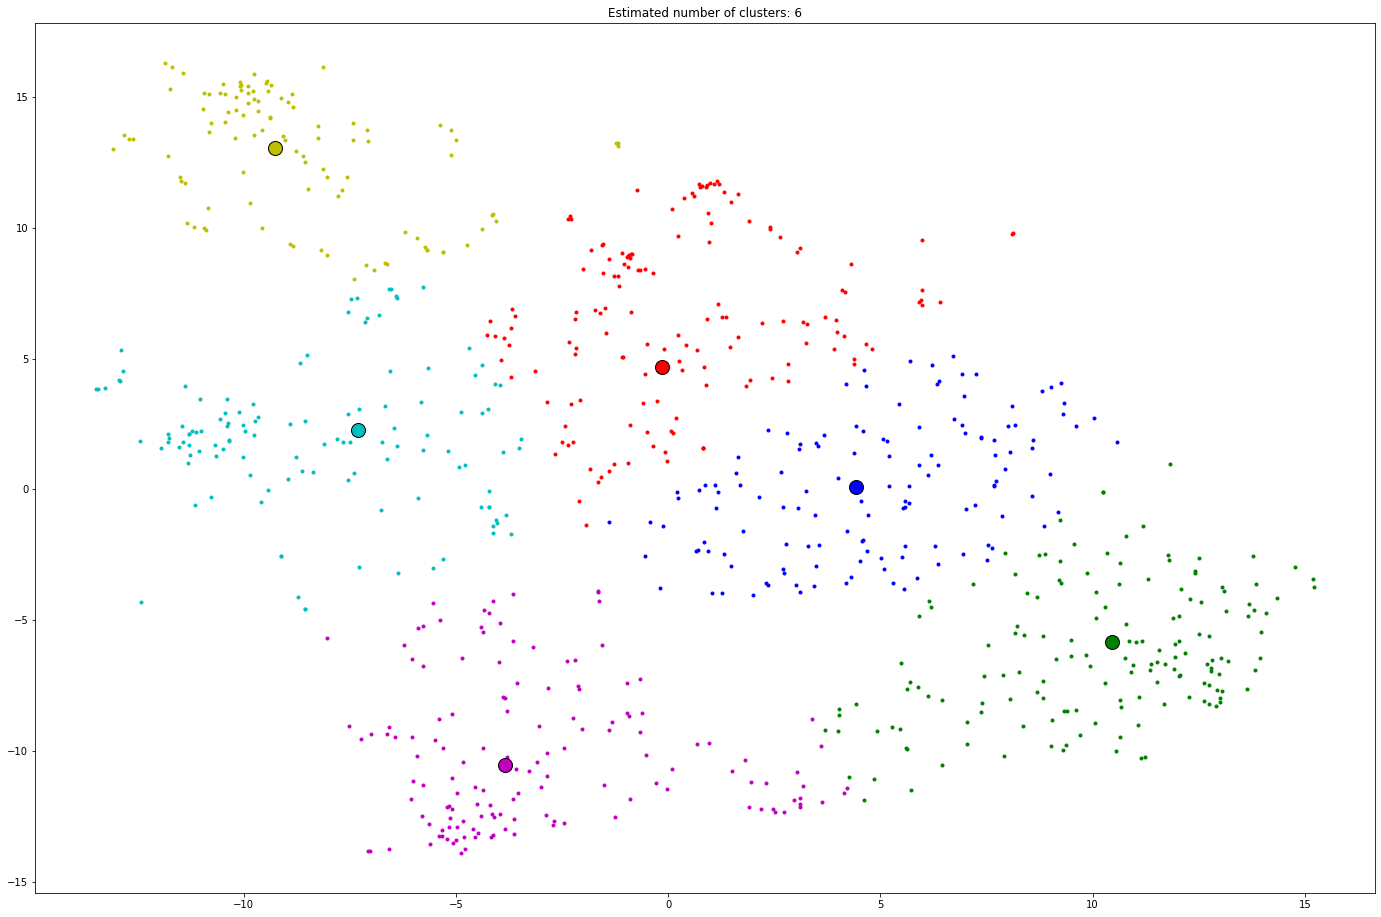

In [402]:
plt.figure()
plt.clf()
X = df.values
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    print(col, cluster_centers[k], k)
    cluster_center = cluster_centers[k]
    plt.plot(X[my_members, 0], X[my_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [403]:
lbls = np.unique(ms.labels_)

In [404]:
res['labels']= ms.labels_

In [405]:
def createdf_dict_by_lbl():
    df_dict = {}
    for i in np.nditer(lbls):
        lbl = 'label-' + str(i)
        df_lbl_i = res[res.labels == i]
        del df_lbl_i['labels']
        df_dict[lbl] = df_lbl_i
    return df_dict
    
def create_df_by_func(func):
    for i in np.nditer(lbls):
        df_lbl_i = res[res.labels == i]
        del df_lbl_i['labels']
        col = 'label-' + str(i)
        if(i == 0):
            df_median = df_lbl_i.agg(func).to_frame()
            df_median = df_median.rename(columns = {0: col})
        else:
            df_median[col] = df_lbl_i.agg(func).values
    return df_median

In [406]:
df_lbl = createdf_dict_by_lbl()

In [407]:
df_median = create_df_by_func('median')
df_mad = create_df_by_func('mad') 

<AxesSubplot:xlabel='description'>

<Figure size 1728x1152 with 0 Axes>

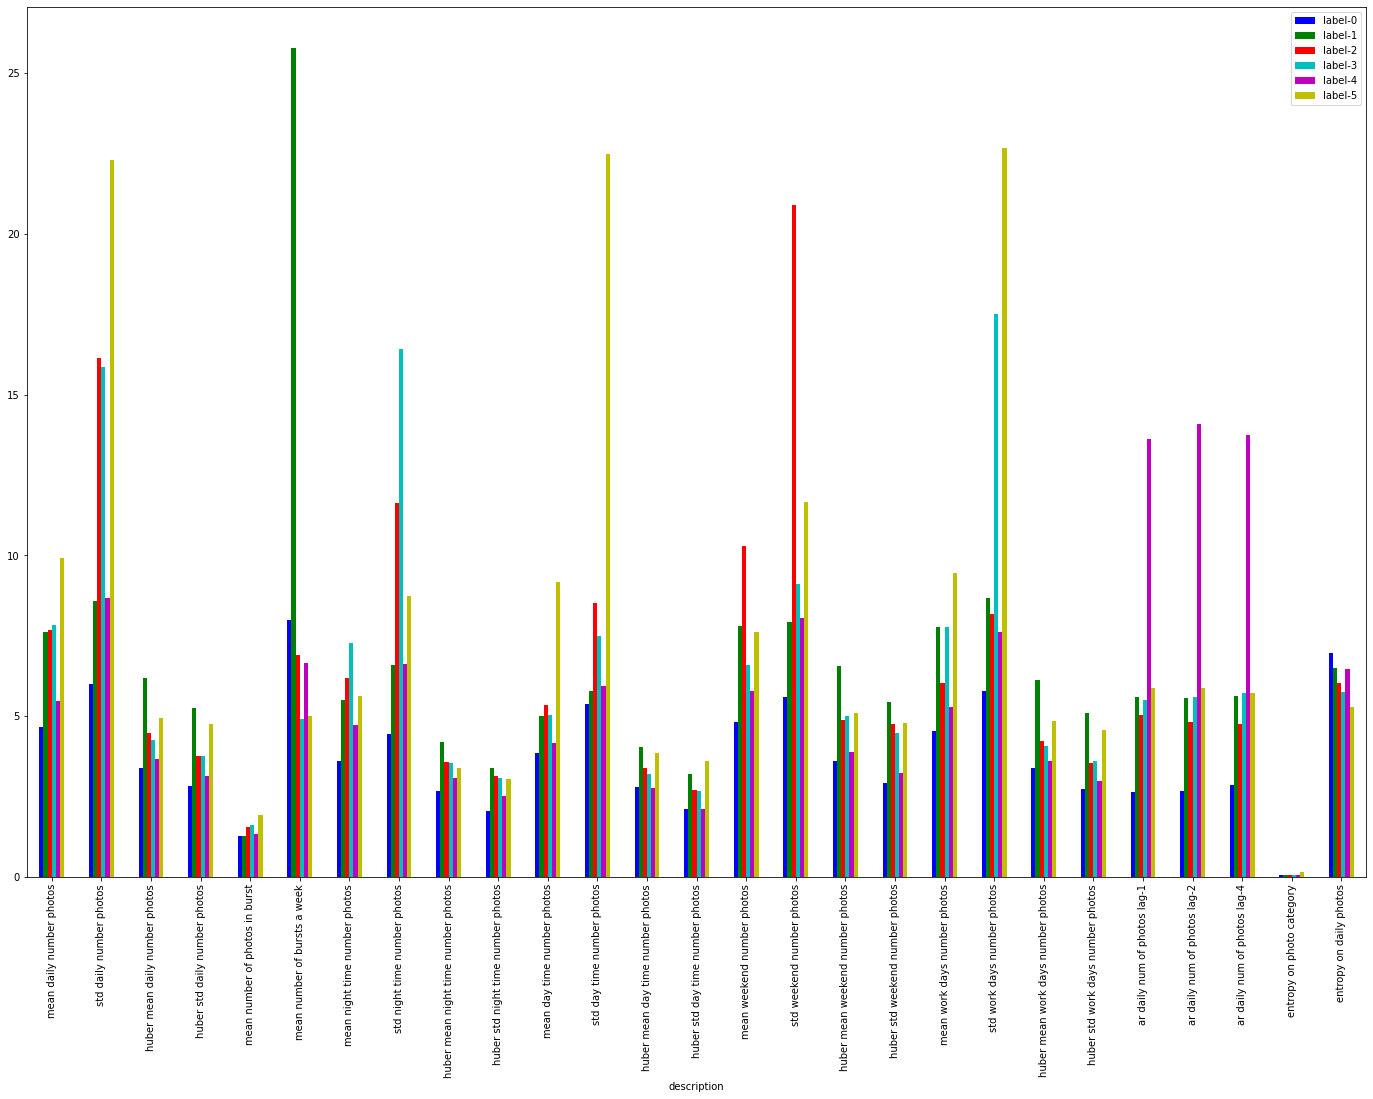

In [419]:
plt.figure()
df_median.plot.bar(color=['b', 'g', 'r', 'c', 'm', 'y'])

<AxesSubplot:xlabel='description'>

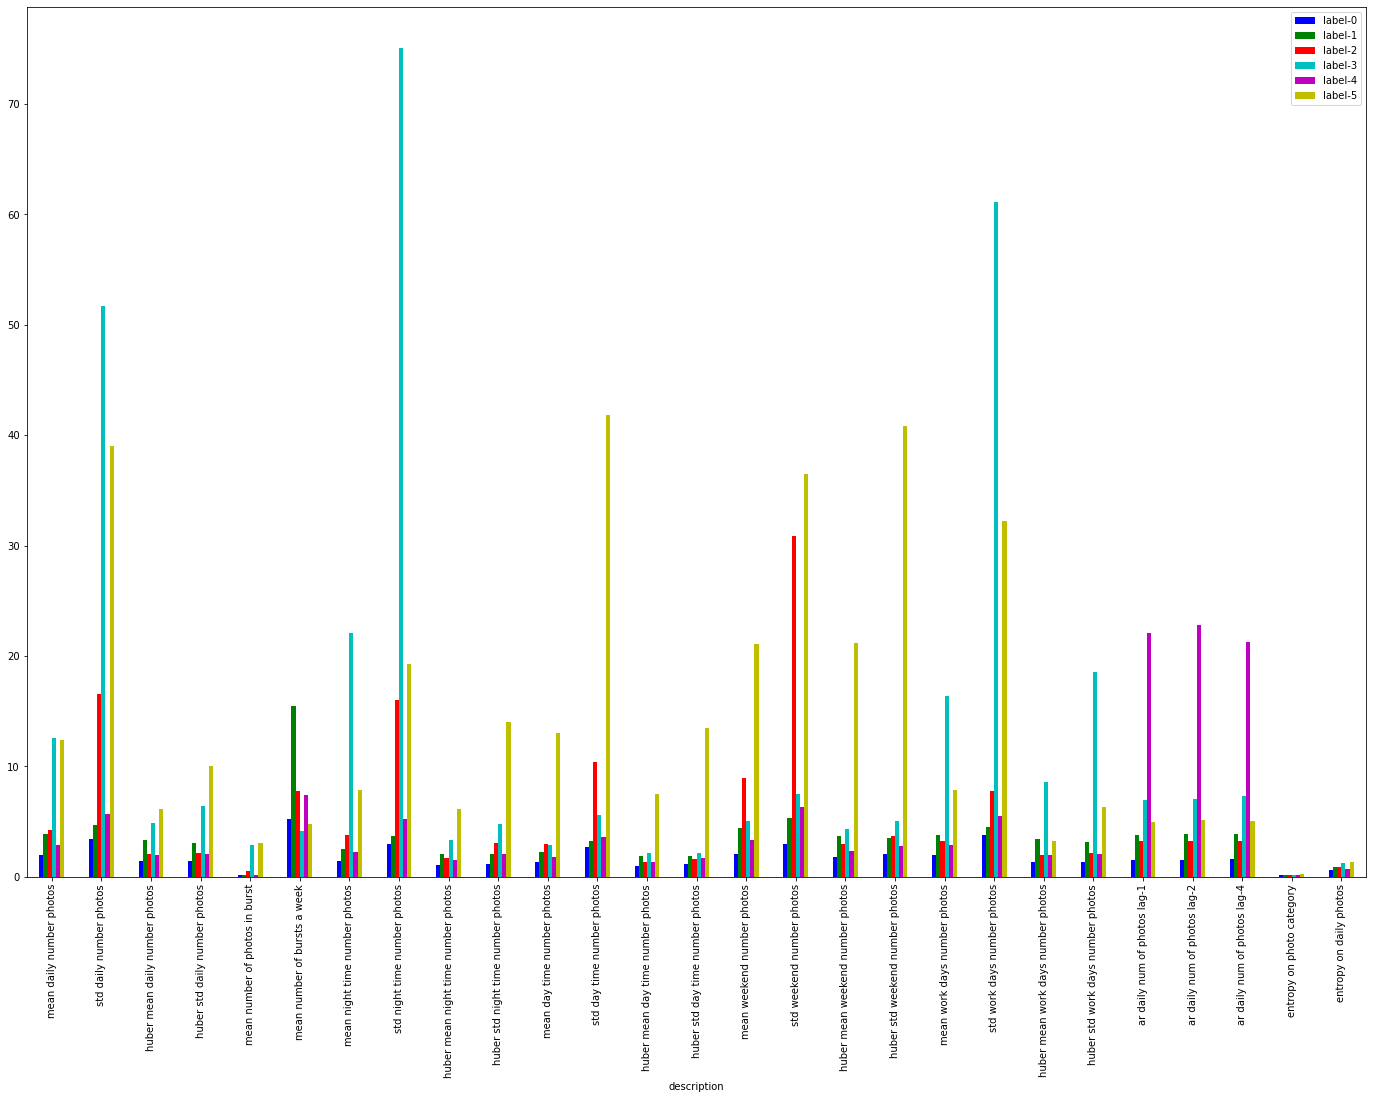

In [420]:
df_mad.plot.bar(color=['b', 'g', 'r', 'c', 'm', 'y'])

In [410]:
#X = df_lbl['label-0'].values
#Y = MinCovDet().fit(X)
#Y.covariance_

In [422]:
df_lbl.keys()

dict_keys(['label-0', 'label-1', 'label-2', 'label-3', 'label-4', 'label-5'])

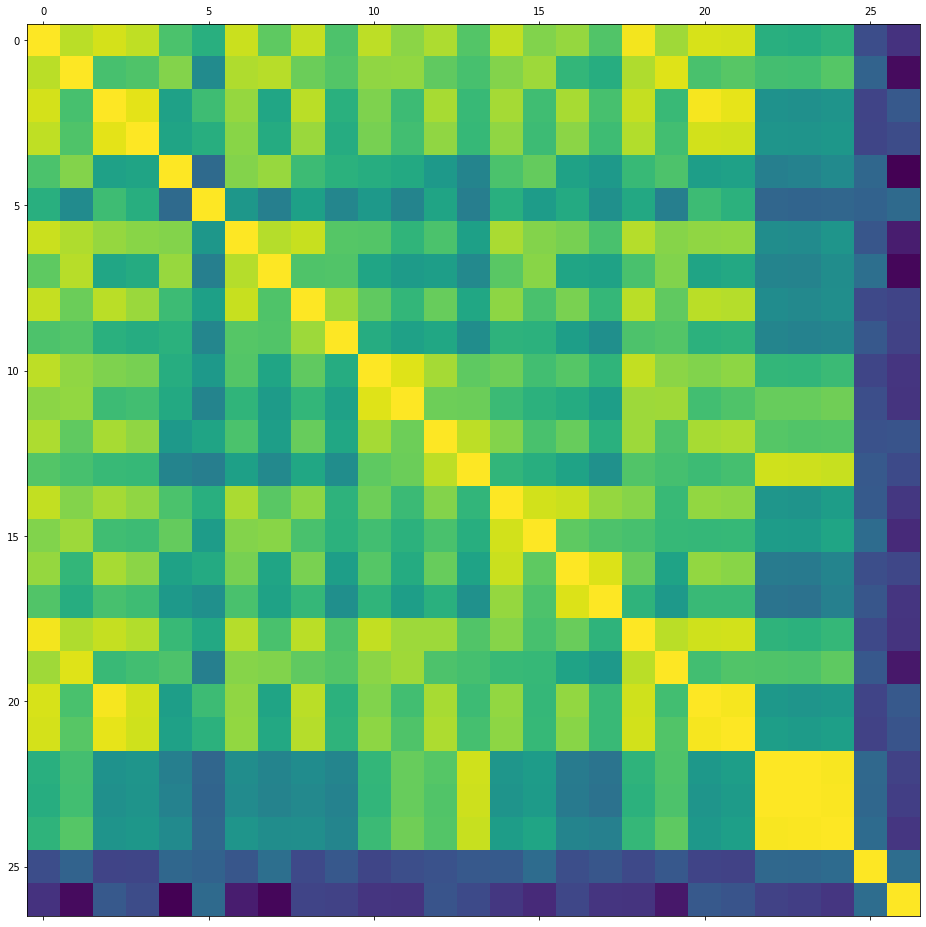

In [424]:
c = df_lbl['label-4'].corr()
plt.matshow(c)
plt.show()

In [264]:
#del df_lbl5['labels']
#dflbl4 = srlbl4.to_frame()
#dflbl4.rename(columns = {0:'lvl-4'})

In [269]:
excel = df0.to_excel('csv_files/photo_gallery_yellow.xlsx')

In [ ]:
#read the tags from firebase json file for user register non register and create df with tag column
def create_tag_df(f): # 'entries.json'
    tag_data = json.load(codecs.open(f, 'r', 'utf-8-sig'))
    df_tag = pd.DataFrame(tag_data)
    df_tag = df_tag.rename(columns={'app_userid': ''})
    dftag = df_tag.set_index('')
    return dftag

In [ ]:
dftag = create_tag_df('entries.json')

In [ ]:
dfjoin = df.join(dftag)

In [ ]:
len(dfjoin)

In [ ]:
dfjoin['User_Register'] = dfjoin['User_Register'].fillna('false')
len(dfjoin[dfjoin.User_Register == 'false'])

In [ ]:
dfjoin.to_csv('csv_files/taged_aggresive_photogallery.csv')

In [ ]:
dfjoin.head(5)

In [ ]:
#sns.scatterplot('population', 'Area', data=df, hue='continent')
#sns.lmplot('population', 'Area', data=df, hue='continent', fit_reg=False)
plt.figure(figsize=(10,8))
sns.lmplot(
    x='x_col', 
    y='y_col',
    data=dfjoin,
    hue='User_Register',
    fit_reg=False,
    height=8,
)
plt.show()

--> tSNE for 3D

In [ ]:
tsne_3d = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300, method='exact')

In [ ]:
nz.shape

In [ ]:
tsne_res_3 = tsne_3d.fit_transform(nz)

In [ ]:
df3 = pd.DataFrame(tsne_res_3, columns=['x_col', 'y_col', 'z_col'], index=inxs)

In [ ]:
df3.head(5)

In [ ]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
plt.axis()
ax.scatter(
    xs = df3['x_col'],
    ys = df3['y_col'],
    zs = df3['z_col'],
    cmap='tab2'
)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_zlim(-12, 12)
plt.show()

In [ ]:
bw = estimate_bandwidth(df3, quantile=0.2, n_samples=200)

In [ ]:
ms = MeanShift(bandwidth=bw, bin_seeding=True)
ms.fit(df3)

In [ ]:
labels = ms.labels_
cluster_centers = ms.cluster_centers_
labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

In [ ]:
cluster_centers

In [ ]:
fig = plt.figure()
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.view_init(45, 180)
plt.axis()
X = df3.values
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(X[my_members, 0], X[my_members, 1], X[my_members, 2], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], cluster_center[2], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
plt.title('Estimated number of 3D clusters: %d' % n_clusters_)
plt.show()

In [ ]:
dfj3 = df3.join(dftag)
dfj3['User_Register'] = dfj3['User_Register'].fillna('false')
dfj3['User_Register'] = dfj3['User_Register'].map({'true': 'blue', 'false': 'red'})

In [ ]:
len(dfj3[dfj3.User_Register == 'blue'])

In [ ]:
%matplotlib inline
#%matplotlib notebook

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
#ax = plt.figure(figsize=(16,10)).gca(projection='3d')
fig = plt.figure()
ax = Axes3D(plt.figure(figsize=(10,8)))
ax.view_init(45, 180)
plt.axis()
ax.scatter(
    xs = dfj3['x_col'],
    ys = dfj3['y_col'],
    zs = dfj3['z_col'],
    c=dfj3['User_Register'],
    cmap='coolwarm'
)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_xlim(-12, 12)
ax.set_ylim(-12, 12)
ax.set_zlim(-12, 12)
plt.show()

In [ ]:
type(ax)